In [1]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
# import datetime
import zipfile
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [2]:
out_path_csv = 'data/lakestats_methods_paper.csv'
df = pd.read_csv(out_path_csv)

fn_basin = 'basins/shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = 'basins/shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = 'basins/shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = 'basins/shapefiles/GroundingLine_Antarctica_v02.shp'
fn_merged =  'basins/shapefiles/ANT_basins_merged.shp'
fn_thresh = 'basins/shapefiles/ANT_basins_thresh1000.shp'

ant_gdf_basin = gpd.read_file(fn_basin)
ant_gdf_shelf = gpd.read_file(fn_shelf)
ant_gdf_coast = gpd.read_file(fn_coast)
ant_gdf_ground = gpd.read_file(fn_ground)
ant_gdf_merged = gpd.read_file(fn_merged)
ant_gdf_thresh = gpd.read_file(fn_thresh)

fn_basin = 'basins/shapefiles/Greenland_Basins_PS_v1.4.2.shp'
fn_merged = 'basins/shapefiles/GRE_basins_merged.shp'
fn_thresh = 'basins/shapefiles/GRE_basins_thresh2000.shp'
gre_gdf_basin = gpd.read_file(fn_basin)
gre_gdf_basin['geometry'] = gre_gdf_basin.geometry.buffer(1)
gre_gdf_merged = gpd.read_file(fn_merged)
gre_gdf_thresh = gpd.read_file(fn_thresh)

gre_bound = gre_gdf_basin.dissolve().boundary
ant_bound = ant_gdf_basin.dissolve().boundary

In [3]:
import ee
import requests
from datetime import datetime 
from datetime import timedelta
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
os.environ["GDAL_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/gdal"
os.environ["PROJ_LIB"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
os.environ["PROJ_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 18,
})

#####################################################################
def get_sentinel2_cloud_collection(area_of_interest, date_time, days_buffer):

    datetime_requested = datetime.strptime(date_time, '%Y-%m-%dT%H:%M:%SZ')
    start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    print('Looking for Sentinel-2 images from %s to %s' % (start_date, end_date), end=' ')

    # Import and filter S2 SR HARMONIZED
    s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Import and filter s2cloudless.
    s2_cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    cloud_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_collection,
        'secondary': s2_cloudless_collection,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    cloud_collection = cloud_collection.map(lambda img: img.addBands(ee.Image(img.get('s2cloudless')).select('probability')))

    def set_is2_cloudiness(img, aoi=area_of_interest):
        cloudprob = img.select(['probability']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                             geometry=aoi, 
                                                             bestEffort=True, 
                                                             maxPixels=1e6)
        return img.set('ground_track_cloud_prob', cloudprob.get('probability'))

    cloud_collection = cloud_collection.map(set_is2_cloudiness)

    return cloud_collection

    
#####################################################################
def download_imagery(fn, lk, gt, imagery_filename, days_buffer=5, max_cloud_prob=15, gamma_value=1.8, buffer_factor=1.2, imagery_shift_days=0):

    # get the bounding box
    lon_rng = gt.lon.max() - gt.lon.min()
    lat_rng = gt.lat.max() - gt.lat.min()
    fac = 0.25
    bbox = [gt.lon.min()-fac*lon_rng, gt.lat.min()-fac*lat_rng, gt.lon.max()+fac*lon_rng, gt.lat.max()+fac*lat_rng]
    poly = [(bbox[x[0]], bbox[x[1]]) for x in [(0,1), (2,1), (2,3), (0,3), (0,1)]]
    roi = ee.Geometry.Polygon(poly)

    # get the earth engine collection
    collection_size = 0
    if days_buffer > 200:
        days_buffer = 200
    increment_days = days_buffer
    while (collection_size<5) & (days_buffer <= 200):
    
        collection = get_sentinel2_cloud_collection(area_of_interest=roi, date_time=lk.date_time, days_buffer=days_buffer)
    
        # filter collection to only images that are (mostly) cloud-free along the ICESat-2 ground track
        cloudfree_collection = collection.filter(ee.Filter.lt('ground_track_cloud_prob', max_cloud_prob))
        
        collection_size = cloudfree_collection.size().getInfo()
        if collection_size == 1: 
            print('--> there is %i cloud-free image.' % collection_size)
        elif collection_size > 1: 
            print('--> there are %i cloud-free images.' % collection_size)
        else:
            print('--> there are not enough cloud-free images: widening date range...')
        days_buffer += increment_days
    
        # get the time difference between ICESat-2 and Sentinel-2 and sort by it 
        is2time = lk.date_time
        def set_time_difference(img, is2time=is2time, imagery_shift_days=imagery_shift_days):
            ref_time = ee.Date(is2time).advance(imagery_shift_days, 'day')
            timediff = ref_time.difference(img.get('system:time_start'), 'second').abs()
            return img.set('timediff', timediff)
        cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')

    # create a region around the ground track over which to download data
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    gt_length = gt.x10.max() - gt.x10.min()
    point_of_interest = ee.Geometry.Point(lon_center, lat_center)
    region_of_interest = point_of_interest.buffer(gt_length*0.5*buffer_factor)

    if collection_size > 0:
        # select the first image, and turn the colleciton into an 8-bit RGB for download
        selectedImage = cloudfree_collection.first()
        mosaic = cloudfree_collection.sort('timediff', False).mosaic()
        rgb = mosaic.select('B4', 'B3', 'B2')
        rgb = rgb.unitScale(0, 10000).clamp(0.0, 1.0)
        rgb_gamma = rgb.pow(1/gamma_value)
        rgb8bit= rgb_gamma.multiply(255).uint8()
        
        # from the selected image get some stats: product id, cloud probability and time difference from icesat-2
        prod_id = selectedImage.get('PRODUCT_ID').getInfo()
        cld_prb = selectedImage.get('ground_track_cloud_prob').getInfo()
        s2datetime = datetime.fromtimestamp(selectedImage.get('system:time_start').getInfo()/1e3)
        s2datestr = datetime.strftime(s2datetime, '%Y-%b-%d')
        is2datetime = datetime.strptime(lk.date_time, '%Y-%m-%dT%H:%M:%SZ')
        timediff = s2datetime - is2datetime
        days_diff = timediff.days
        if days_diff == 0: diff_str = 'Same day as'
        if days_diff == 1: diff_str = '1 day after'
        if days_diff == -1: diff_str = '1 day before'
        if days_diff > 1: diff_str = '%i days after' % np.abs(days_diff)
        if days_diff < -1: diff_str = '%i days before' % np.abs(days_diff)
        
        print('--> Closest cloud-free Sentinel-2 image:')
        print('    - product_id: %s' % prod_id)
        print('    - time difference: %s' % timediff)
        print('    - mean cloud probability: %.1f' % cld_prb)
        
        # get the download URL and download the selected image
        success = False
        scale = 10
        tries = 0
        while (success == False) & (tries <= 7):
            try:
                downloadURL = rgb8bit.getDownloadUrl({'name': 'mySatelliteImage',
                                                          'crs': selectedImage.select('B3').projection().crs(),
                                                          'scale': scale,
                                                          'region': region_of_interest,
                                                          'filePerBand': False,
                                                          'format': 'GEO_TIFF'})
        
                response = requests.get(downloadURL)
                with open(imagery_filename, 'wb') as f:
                    f.write(response.content)
        
                print('--> Downloaded the 8-bit RGB image as %s.' % imagery_filename)
                success = True
                tries += 1
            except:
                traceback.print_exc()
                scale *= 2
                print('-> download unsuccessful, increasing scale to %.1f...' % scale)
                success = False
                tries += 1

            
#####################################################################
def plot_imagery(fn, days_buffer=5, max_cloud_prob=15, xlm=[None, None], ylm=[None, None], gamma_value=1.8, imagery_filename=None,
                 re_download=True, ax=None, buffer_factor=1.2, imagery_shift_days=0, increase_gtwidth=1):
                     
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+lk.max_depth
    if not imagery_filename:
        imagery_filename = 'imagery' + fn[fn.rfind('/'):].replace('.h5','.tif')
    
    
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    
    dfd = lk.depth_data.copy()
    dfd.xatc -= x_off

    # get the ground track
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().reset_index()
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    
    if ((not os.path.isfile(imagery_filename)) or re_download) and ('modis' not in imagery_filename):
        download_imagery(fn=fn, lk=lk, gt=gt, imagery_filename=imagery_filename, days_buffer=days_buffer, 
                         max_cloud_prob=max_cloud_prob, gamma_value=gamma_value, buffer_factor=buffer_factor, 
                         imagery_shift_days=imagery_shift_days)
    
    try:
        myImage = rio.open(imagery_filename)
        
        # make the figure
        if not ax:
            fig, ax = plt.subplots(figsize=[6,6])
        
        rioplot.show(myImage, ax=ax)
        ax.axis('off')
        # add_graticule(img=myImage, ax_img=ax)
        
        # add some info about the Sentinel-2 image
        # txt = '%s' % lk.date_time[:10]
        # ax.text(0.0, -0.01, txt, transform=ax.transAxes, ha='left', va='top',fontsize=6)
    
        ximg, yimg = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=np.array(gt.lon), ys=np.array(gt.lat))
        if 'modis' in imagery_filename:
            xrng = ximg[-1] - ximg[0]
            yrng = yimg[-1] - yimg[0]
            fac = 5
            print('using saved modis image')
            ax.plot([ximg[-1]+fac*xrng,ximg[0]-fac*xrng], [yimg[-1]+fac*yrng, yimg[0]-fac*yrng], 'k:', lw=1)
            ax.annotate('', xy=(ximg[-1]+fac*xrng, yimg[-1]+fac*yrng), xytext=(ximg[0]-fac*xrng, yimg[0]-fac*yrng),
                             arrowprops=dict(width=0, lw=0, headwidth=5, headlength=5, color='k'),zorder=1000)
            ax.plot(ximg, yimg, 'r-', lw=1, zorder=5000)
        else:
            print('plotting ground track')
            ax.annotate('', xy=(ximg[-1], yimg[-1]), xytext=(ximg[0], yimg[0]),
                             arrowprops=dict(width=0.7*increase_gtwidth, headwidth=5*increase_gtwidth, 
                                             headlength=5*increase_gtwidth, color='k'),zorder=1000)

            isdepth = dfd.depth>0
            bed = dfd.h_fit_bed
            bed[~isdepth] = np.nan
            bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
            surf = np.ones_like(dfd.xatc) * lk.surface_elevation
            surf[~isdepth] = np.nan
            xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
            lon_bed = np.array(dfd.lon)
            lat_bed = np.array(dfd.lat)
            lon_bed[(np.isnan(surf)) & (np.isnan(bed))] = np.nan
            lat_bed[(np.isnan(surf)) & (np.isnan(bed))] = np.nan
            xb, yb = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=lon_bed, ys=lat_bed)
            ax.plot(xb, yb, 'r-', lw=increase_gtwidth, zorder=5000)
        
        if not ax:
            fig.tight_layout(pad=0)
    
        return myImage, lon_center, lat_center
    except: 
        return None, lon_center, lat_center
        traceback.print_exc()

                     
#####################################################################
def plotIS2(fn, ax=None, xlm=[None, None], ylm=[None,None], cmap=cmc.lapaz_r, name='ICESat-2 data',increase_linewidth=1):
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    dfd = lk.depth_data.copy()
    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+1.5*lk.max_depth
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    dfd = dfd[(dfd.xatc >= xlm[0]) & (dfd.xatc <= xlm[1]) & (dfd.h_fit_bed >= ylm[0])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    dfd.xatc -= x_off
    
    isdepth = dfd.depth>0
    bed = dfd.h_fit_bed
    bed[~isdepth] = np.nan
    bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
    surf = np.ones_like(dfd.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    surf_only = surf[~np.isnan(surf)]
    bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]
    xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
    xatc_bed = np.array(dfd.xatc)[(~np.isnan(surf)) & (~np.isnan(bed))]
    
    # make the figure
    if not ax:
        fig, ax = plt.subplots(figsize=[8,5])

    df['is_afterpulse']= df.prob_afterpulse > np.random.uniform(0,1,len(df))
    if not cmap:
        ax.scatter(df.xatc[~df.is_afterpulse], df.h[~df.is_afterpulse], s=1, c='k')
    else:
        ax.scatter(df.xatc, df.h, s=1, c=df.snr, cmap=cmap)
        
    # ax.scatter(dfd.xatc[isdepth], dfd.h_fit_bed[isdepth], s=4, color='r', alpha=dfd.conf[isdepth])
    # ax.plot(dfd.xatc, dfd.h_fit_bed, color='gray', lw=0.5)
    ax.plot(dfd.xatc, bed, color='r', lw=increase_linewidth)
    ax.plot(dfd.xatc, surf, color='C0', lw=increase_linewidth)

    # add the length of surface
    arr_y = lk.surface_elevation+lk.max_depth*0.25
    x_start = np.min(xatc_surf)
    x_end = np.max(xatc_surf)
    x_mid = (x_end + x_start) / 2
    len_surf_m = np.floor((x_end-x_start)/100)*100
    len_surf_km = len_surf_m/1000
    arr_x1 = x_mid - len_surf_m / 2
    arr_x2 = x_mid + len_surf_m / 2
    ax.annotate('', xy=(arr_x1, arr_y), xytext=(arr_x2, arr_y),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
    ax.annotate('', xy=(arr_x2, arr_y), xytext=(arr_x1, arr_y),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
    ax.text(x_mid, arr_y, r'\textbf{%.1f km}' % len_surf_km, fontsize=plt.rcParams['font.size']+2, ha='center', va='bottom', color='C0', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))

    # add the max depth
    y_low = np.min(bed_only)
    y_up = lk.surface_elevation
    arr_x = xatc_bed[np.argmin(bed_only)]
    arr_x = xlm[0] - 0.0* (xlm[1] - xlm[0])
    y_len = y_up - y_low
    y_mid = (y_up + y_low) / 2
    arr_len = y_len
    arr_y1 = y_mid + arr_len / 2
    arr_y2 = y_mid - arr_len / 2
    ref_index = 1.33
    dep_round = np.round(y_len / ref_index, 1)
    ax.annotate('', xy=(arr_x, arr_y2), xytext=(arr_x, arr_y1),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
    ax.annotate('', xy=(arr_x, arr_y1), xytext=(arr_x, arr_y2),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
    ax.text(arr_x, y_mid, r'\textbf{%.1f m}' % dep_round, fontsize=plt.rcParams['font.size']+2, ha='right', va='center', color='r', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.8, lw=0, boxstyle='round,pad=0.2,rounding_size=0.5'), rotation=90)

    # add the title
    datestr = datetime.strftime(datetime.strptime(lk.date_time[:10],'%Y-%m-%d'), '%d %B %Y')
    if True:
        sheet = lk.ice_sheet
        region = lk.polygon_filename.split('_')[-1].replace('.geojson', '')
        if sheet == 'AIS':
            region = region + ' (%s)' % lk.polygon_filename.split('_')[-2]
        latstr = lk.lat_str[:-2] + '°' + lk.lat_str[-1]
        lonstr = lk.lon_str[:-2] + '°' + lk.lon_str[-1]
        name = '(%s, %s), %d m.a.s.l.' % (latstr, lonstr, np.round(lk.surface_elevation))
    
    ax.text(0.5, 0.87, '%s' % name, fontsize=plt.rcParams['font.size'], ha='center', va='top', transform=ax.transAxes,
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0), fontweight='bold')
    ax.text(0.5, 0.89, r'\textbf{%s}' % datestr, fontsize=plt.rcParams['font.size']+2, ha='center', va='bottom', transform=ax.transAxes,
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))
    ax.set_xlim(xlm)
    ax.set_ylim(ylm)
    ax.axis('off')

    
#####################################################################
def plot_IS2_imagery(fn, axes=None, xlm=[None,None], ylm=[None,None], cmap=None, days_buffer=5, max_cloud_prob=15, 
                     gamma_value=1.8, imagery_filename=None, re_download=True, img_aspect=3/2, name='ICESat-2 data',
                     return_fig=False, imagery_shift_days=0.0, increase_linewidth=1, increase_gtwidth=1):

    if not axes:
        fig = plt.figure(figsize=[12,6], dpi=80)
        gs = fig.add_gridspec(1,3)
        axp = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:])]
    else:
        axp = axes
        
    ax = axp[1]
    plotIS2(fn=fn, ax=ax, xlm=xlm, ylm=ylm, cmap=cmap, name=name, increase_linewidth=increase_linewidth)
    
    ax = axp[0]
    img, center_lon, center_lat = plot_imagery(fn=fn, days_buffer=days_buffer, max_cloud_prob=max_cloud_prob, xlm=xlm, ylm=ylm, 
        gamma_value=gamma_value, imagery_filename=imagery_filename, re_download=re_download, ax=ax, imagery_shift_days=imagery_shift_days,
        increase_gtwidth=increase_gtwidth)
        
    if img:        
        if imagery_filename:
            if 'modis' in imagery_filename:
                center_x, center_y = warp.transform(src_crs='epsg:4326', dst_crs=img.crs, xs=[center_lon], ys=[center_lat])
                center_x = center_x[0]
                center_y = center_y[0]
                rng = 75000
                if img_aspect > 1:
                    ax.set_xlim(center_x - 0.5*rng/img_aspect, center_x + 0.5*rng/img_aspect)
                    ax.set_ylim(center_y - 0.5*rng, center_y + 0.5*rng)
                if img_aspect < 1:
                    ax.set_xlim(center_x - 0.5*rng, center_x + 0.5*rng)
                    ax.set_ylim(center_y - 0.5*rng*img_aspect, center_y + 0.5*rng*img_aspect)
                
        elif (img_aspect > 1): 
            h_rng = img.bounds.top - img.bounds.bottom
            cntr = (img.bounds.right + img.bounds.left) / 2
            ax.set_xlim(cntr-0.5*h_rng/img_aspect, cntr+0.5*h_rng/img_aspect)
        elif img_aspect < 1: 
            w_rng = img.bounds.right - img.bounds.left
            cntr = (img.bounds.top + img.bounds.bottom) / 2
            ax.set_ylim(cntr-0.5*w_rng*img_aspect, cntr+0.5*w_rng/img_aspect)
            
    
    if not axes:
        fig.tight_layout(pad=1, h_pad=0, w_pad=0)
        if not name:
            name = 'zzz' + lk.polygon_filename.split('_')[-1].replace('.geojson', '')
        outname = 'figplots/' + name.replace(' ', '') + fn[fn.rfind('/')+1:].replace('.h5','.jpg')
        fig.savefig(outname, dpi=300)

    if return_fig:
        plt.close(fig)
        return center_lon, center_lat, fig
    else:
        return center_lon, center_lat

#####################################################################
def plot_coords(coords, ax, crs_dst, crs_src='EPSG:4326', text=None, color='b', ms=10, fs=18, annot_loc={}):
    coords_trans = warp.transform(src_crs=crs_src, dst_crs=crs_dst, xs=[coords[0]], ys=[coords[1]])
    x = coords_trans[0][0]
    y = coords_trans[1][0]
    if text:
        text = r'\textbf{%s}' % text
    if not text:
        ax.scatter(x, y, coords_trans[1][0], s=ms, color=color)
    elif ('x' not in annot_loc.keys()) and ('y' not in annot_loc.keys()):
        ax.text(x, y, text, fontsize=fs, color='white', ha='center', va='center', fontweight='bold',
                bbox=dict(facecolor=color, alpha=1, boxstyle='round,pad=0.3,rounding_size=0.5', lw=0))
    else:
        ax.annotate(' ', xy=(x,y), xytext=(annot_loc['x'], annot_loc['y']),
                    ha='center',va='center', arrowprops=dict(width=1, headwidth=5, headlength=5, color=color),zorder=1000)
        ax.text(annot_loc['x'], annot_loc['y'], text, fontsize=fs, color='white', ha='center', va='center',
                bbox=dict(facecolor=color, alpha=1, boxstyle='round,pad=0.3,rounding_size=0.5', lw=0), zorder=2000, fontweight='bold')
        
def add_letter(ax, text, fs=16, col='b'):
    ax.text(0.09,0.95,r'\textbf{%s}'%text,color='w',fontsize=fs,ha='left', va='top', fontweight='bold',
              bbox=dict(fc=col, boxstyle='round,pad=0.3,rounding_size=0.5', lw=0), transform=ax.transAxes)

In [51]:
min_area = 0.01
melt_color = '#0692cf'

def plot_region(region, meltseasons, axes=None, increase_scatter=1):
    if region == 'B-C':
        region_name = 'Amery Catchment'
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        if not axes:
            fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
        leg_loc = 'upper left'
    if region == 'CW':
        region_name = 'Central West Greenland'
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        if not axes:
            fig, axs = plt.subplots(figsize=[6,6], nrows=1, ncols=2)
        leg_loc = 'upper right'

    dfl = df[df.basin_name == region]
    if axes:
        axs = np.array(axes)
    axs = axs.flatten()

    lakedfs = []
    
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
            
        scattlabel = r'ICESat-2 lakes: $%i$ total' % len(dfs)
        if region == 'CW':
            scattlabel = scattlabel.replace(':', ':\n').replace('ICESat-2 ', 'ICESat-2\n')
        scatt = ax.scatter(gdfs.x, gdfs.y, s=increase_scatter, c='r', alpha=1, zorder=100, label=scattlabel)
        scatt = ax.scatter(-99999999, -99999999, s=increase_scatter*4, c='r', alpha=1, zorder=100, label=scattlabel)
        lakedfs.append(gdfs)

        #############################################################################################################
        # ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        # .explode(index_parts=False).to_crs(base_crs)
        # patch_areas = ext.geometry.area / 1e6
        # ext = ext[patch_areas > min_area].simplify(60)
        # total_area = np.sum(patch_areas[patch_areas > min_area])
        # ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)
        #############################################################################################################
        total_area = 9999.9
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        # ax.set_title('%s' % meltseason, fontsize=14)

        patchlabel = r'Landsat melt extent: $%d$ km$^2$' % total_area
        if region == 'CW':
            patchlabel = patchlabel.replace(':', ':\n').replace('Landsat ', '').replace('melt ', 'melt\n')
        melt_patch = mpatches.Patch(color=melt_color, label=patchlabel)
        if region_name == 'B-C':
            ax.legend(handles=[scatt,melt_patch], loc=leg_loc)
            ax.set_title(r'\textbf{%s, %s}' % (region_name,meltseason), fontsize=plt.rcParams['font.size']+8)
        else:
        #     #ax.set_title(r'\textbf{Central West}\n\textbf{Greenland}\n\textbf{%s}' % meltseason, fontsize=plt.rcParams['font.size']+6)
            ax.legend(handles=[scatt,melt_patch], loc=leg_loc, title=r'\textbf{%s}' % meltseason)
        #     ax.set_title(r'\textbf{Central West }'
        #                  r'\textbf{Greenland}', fontsize=plt.rcParams['font.size']+6, wrap=True)
        #                  # r'\textbf{%s}' % meltseason

    if not axes:
        fig.tight_layout()
        fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

    return lakedfs

Looking for Sentinel-2 images from 2020-07-20T23:04:38Z to 2020-09-18T23:04:38Z --> there are 20 cloud-free images.
--> Closest cloud-free Sentinel-2 image:
    - product_id: S2B_MSIL2A_20200820T153819_N0214_R011_T22WEE_20200820T180507
    - time difference: 9:38:09.296000
    - mean cloud probability: 2.8
--> Downloaded the 8-bit RGB image as imagery/lake_09887085_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200819230220_08490805_006_01_gt2l_0001.tif.
plotting ground track


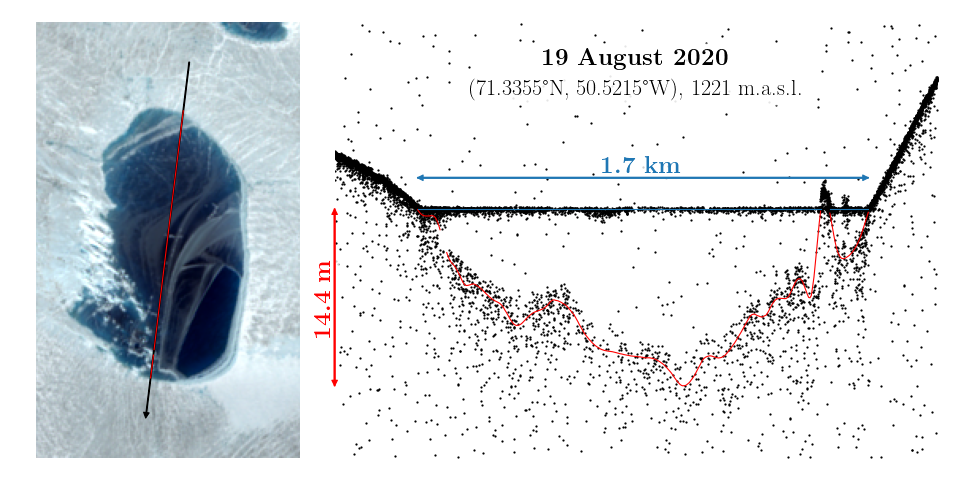

In [68]:
settings = {
    're_download': True,
    'img_aspect': 1.65,
    'days_buffer': 30,
}

cw19_deepest = {
    'fn': 'data/lakes/lake_09421694_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190814163946_07270405_006_02_gt2l_0007.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}

cw20_deepest = {
    'fn': 'data/lakes/lake_09997475_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200717114945_03380803_006_01_gt3l_0020.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}

cw20_2nddeepest = {
    'fn': 'data/lakes/lake_09887085_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200819230220_08490805_006_01_gt2l_0001.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}


toplot = cw20_2nddeepest
plot_IS2_imagery(**toplot, **settings)

lk = dictobj(read_melt_lake_h5(toplot['fn']))
# # fig = lk.plot_lake()

# GREENLAND MAP

plotting ground track
plotting ground track


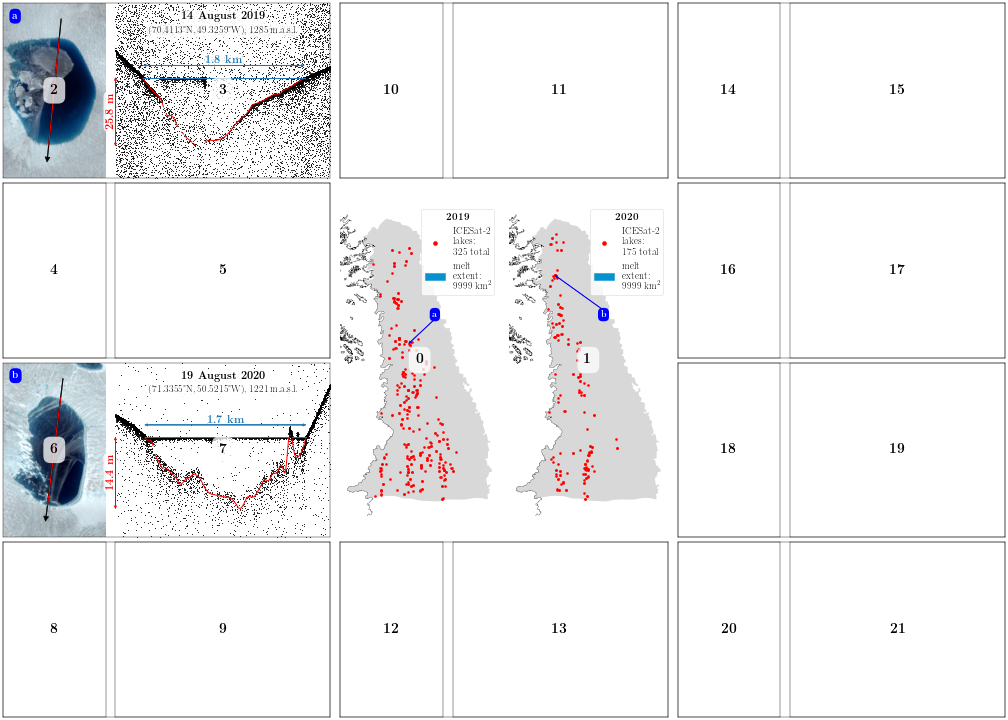

In [69]:
plt.close('all')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 20,
})

figsize = [28,20]
ncols = 18
nrows = 4
aspect = figsize[1]/figsize[0]*nrows/ncols
fig = plt.figure(figsize=figsize, dpi=36)
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
axs = []
axs.append(fig.add_subplot(gs[1:3, 6:9])) # 2018-19
axs.append(fig.add_subplot(gs[1:3, 9:12])) # 2019-20
lakedfs = plot_region(region='CW', meltseasons=['2019', '2020'], axes=axs[:2], increase_scatter=16)

for j in range(3):
    for i in range(4):
        if not ((i in [1,2]) and (j==1)):
            axs.append(fig.add_subplot(gs[i, j*6:j*6+2]))
            axs.append(fig.add_subplot(gs[i, j*6+2:(j+1)*6]))     
            
fsz_letters = 20
color_letters = 'b'

##########################################
# LAKE PLOTS (ICESat-2 and imagery)
settings = {
    're_download': False,  # to avoid, re-downloading scenes that were already acquired
    'img_aspect': 1.71,  # adjust to fill max space in the figure
    'increase_linewidth': 2,  # for depth data linewidth
    'increase_gtwidth': 2,  # for ground track arrow size
}

# 2019 season
ax_map = axs[0] 

thesubplots = [
    [cw19_deepest, 2, {'x': -120766.547, 'y': -2090835.828}],
]

for i_plot,loc in enumerate(thesubplots):
    coords = plot_IS2_imagery(**loc[0], axes=axs[loc[1]:loc[1]+2], **settings)
    plot_coords(coords, ax=ax_map, crs_dst=gre_bound.crs, text=r'\textbf{%s}' % chr(ord('a')+i_plot), annot_loc=loc[2])
    add_letter(ax=axs[loc[1]], text=r'\textbf{%s}' % chr(ord('a')+i_plot), fs=fsz_letters, col=color_letters)

# 2020 season
ax_map = axs[1] 
istart = len(thesubplots)

thesubplots = [
    [cw20_2nddeepest, 6, {'x': -120766.547, 'y': -2090835.828}],
]

for i_plot,loc in enumerate(thesubplots):
    coords = plot_IS2_imagery(**loc[0], axes=axs[loc[1]:loc[1]+2], **settings)
    plot_coords(coords, ax=ax_map, crs_dst=gre_bound.crs, text=r'\textbf{%s}' % chr(ord('a')+i_plot+istart), annot_loc=loc[2])
    add_letter(ax=axs[loc[1]], text=r'\textbf{%s}' % chr(ord('a')+i_plot+istart), fs=fsz_letters, col=color_letters)

# remove tick marks
for i in range(len(axs)):
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])

axboxs = []
for j in range(3):
    for i in range(4):
        if not ((i in [1,2]) and (j==1)):
            axboxs.append(fig.add_subplot(gs[i, j*6:(j+1)*6]))
            axboxs[-1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
            axboxs[-1].patch.set_facecolor('none')

# axbox_center = fig.add_subplot(gs[1:3, 6:12])
# axbox_center.axis('off')
# axbox_center.text(0.5, 0.995, '\n' + r'\textbf{Central West Greenland}', fontsize=26, transform=axbox_center.transAxes, 
#                   ha='center', va='center')
            
fig.tight_layout(pad=0.3, h_pad=0.5, w_pad=0.5)
# fig.savefig('plots/results_map_greenland_cw.jpg', dpi=300)

# for getting arrow start coordinates
coords = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("'x': %.3f, 'y': %.3f" % (ix,iy))
    global coords
    coords.append((ix,iy))
    if len(coords) > 100:
        fig.canvas.mpl_disconnect(cid)
    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# numbers for subplots
for iax, ax in enumerate(axs):
    ax.text(0.5, 0.5, r'\textbf{%d}'%iax, transform=ax.transAxes, ha='center', va='center', fontsize=28, zorder=10000,
           bbox=dict(facecolor='white', alpha=0.75, boxstyle='round,pad=.5,rounding_size=0.5', lw=0))

In [65]:
print("'x': %.3f, 'y': %.3f" % (coords[-1][0], coords[-1][1]))

'x': -120766.547, 'y': -2090835.828


In [55]:
settings = {
    're_download': True,
    'img_aspect': 1.65,
    'days_buffer': 30,
}

amery18_deep = {
    'fn': 'data/validation/fluidsurrf_out/lake_09989-09335_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0010.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}

amery20_deep = {
    'fn': 'data/validation/fluidsurrf_out/lake_10000-09764_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210204190842_06531012_006_01_gt3r_0000.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}

amery20_small = {
    'fn': 'data/lakes/lake_09992092_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20201225080953_00201010_006_01_gt3l_0001.h5',
    'gamma_value': 0.5,
    'xlm': [None, None],
    'ylm': [None, None],
    'imagery_shift_days': 3,
    'max_cloud_prob': 50
}

amery20_flat = {
    'fn': 'data/validation/fluidsurrf_out/lake_10000-10000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210204190842_06531012_006_01_gt3l_0000.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
    'imagery_shift_days': 0,
    'max_cloud_prob': 50
}

amery20_4 = {
    'fn': 'data/lakes/lake_10000000_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210111071058_02791010_006_01_gt3r_0004.h5',
    'gamma_value': 0.5,
    'xlm': [None, None],
    'ylm': [None, None],
}

amery20_bedrock = {
    'fn': 'data/lakes/lake_09999803_AIS_2020-21_simplified_ANT_1000_East_B-C_ATL03_20210107071914_02181010_006_01_gt1l_0000.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}

amery18_1 = {
    'fn': 'data/lakes/lake_09813379_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190115175225_02790210_006_02_gt2l_0009.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
    'imagery_shift_days': 2,
    'max_cloud_prob': 50
}

amery18_dolinelong = {
    'fn': 'data/lakes/lake_09991923_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190123173555_04010210_006_02_gt2l_0003.h5',
    'gamma_value': 0.3,
    'xlm': [None, None],
    'ylm': [None, None],
    'imagery_shift_days': 0,
    'max_cloud_prob': 30
}

amery18_upstream = {
    'fn': 'data/lakes/lake_09903464_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2r_0080.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
    'imagery_shift_days': 0,
    'max_cloud_prob': 30
}

amery18_beaver = {
    'fn': 'data/lakes/lake_09848326_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt1r_0023.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
    'imagery_shift_days': 0,
    'max_cloud_prob': 30
}

amery18_frozen = {
    'fn': 'data/lakes/lake_09981760_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190221161201_08430210_006_02_gt3l_0003.h5',
    'gamma_value': 0.3,
    'xlm': [None, None],
    'ylm': [None, None],
    'imagery_shift_days': 0,
    'max_cloud_prob': 30
}

# toplot = amery20_small
# plot_IS2_imagery(**toplot, **settings)

# lk = dictobj(read_melt_lake_h5(toplot['fn']))
# # fig = lk.plot_lake()

# AMERY MAP

plotting ground track
plotting ground track
plotting ground track
plotting ground track
plotting ground track
plotting ground track
plotting ground track
plotting ground track
plotting ground track
plotting ground track


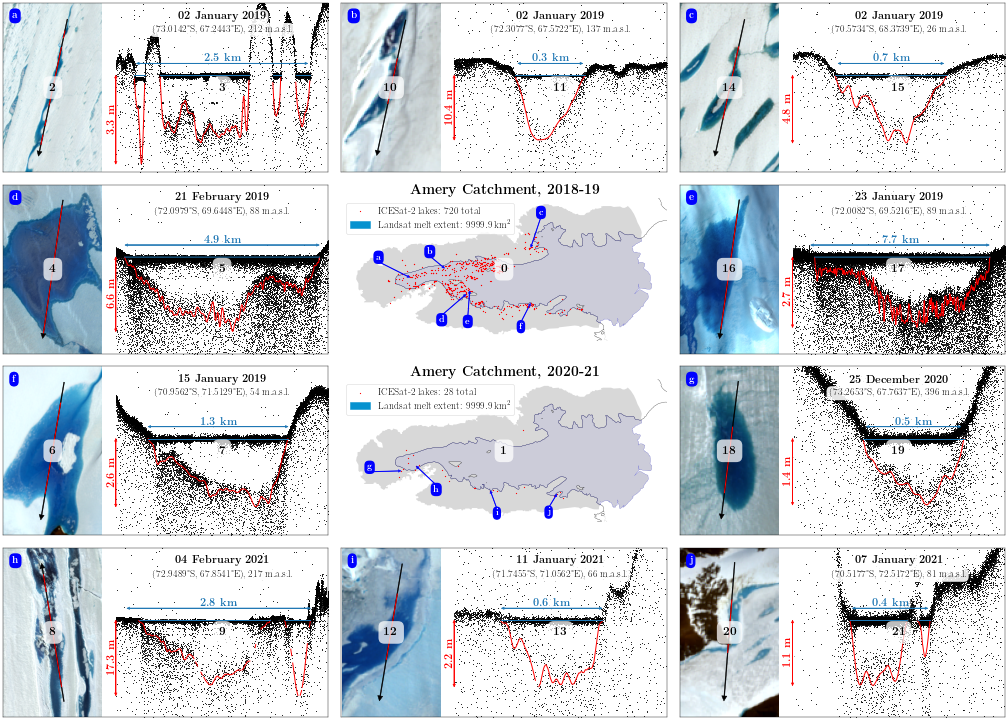

In [16]:
plt.close('all')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 20,
})

figsize = [28,20]
ncols = 9
nrows = 4
aspect = figsize[1]/figsize[0]*nrows/ncols
fig = plt.figure(figsize=figsize, dpi=36)
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
axs = []
axs.append(fig.add_subplot(gs[1, 3:6])) # 2018-19
axs.append(fig.add_subplot(gs[2, 3:6])) # 2019-20
lakedfs = plot_region(region='B-C', meltseasons=['2018-19', '2020-21'], axes=axs[:2])

for j in range(3):
    for i in range(4):
        if not ((i in [1,2]) and (j==1)):
            axs.append(fig.add_subplot(gs[i, j*3]))
            axs.append(fig.add_subplot(gs[i, j*3+1:(j+1)*3]))     
            
fsz_letters = 20
color_letters = 'b'

##########################################
# LAKE PLOTS (ICESat-2 and imagery)
settings = {
    're_download': False,  # to avoid, re-downloading scenes that were already acquired
    'img_aspect': 1.71,  # adjust to fill max space in the figure
    'increase_linewidth': 2,  # for depth data linewidth
    'increase_gtwidth': 2,  # for ground track arrow size
}

# 2018-19 season
ax_map = axs[0] 

thesubplots = [
    [amery18_upstream, 2, {'x': 1645286.005, 'y': 763183.078}],
    [amery18_deep, 10, {'x': 1758009.962, 'y': 775776.284}],
    [amery18_beaver, 14, {'x': 2002778.100, 'y': 861895.339}],
    [amery18_frozen, 4, {'x': 1784310.709, 'y': 625708.813}],
    [amery18_dolinelong, 16, {'x': 1841685.983, 'y': 621925.830}],
    [amery18_1, 6, {'x': 1958643.273, 'y': 610523.861}],
]

for i_plot,loc in enumerate(thesubplots):
    coords = plot_IS2_imagery(**loc[0], axes=axs[loc[1]:loc[1]+2], **settings)
    plot_coords(coords, ax=ax_map, crs_dst=ant_bound.crs, text=r'\textbf{%s}' % chr(ord('a')+i_plot), annot_loc=loc[2])
    add_letter(ax=axs[loc[1]], text=r'\textbf{%s}' % chr(ord('a')+i_plot), fs=fsz_letters, col=color_letters)

# 2020-21 season
ax_map = axs[1] 
istart = len(thesubplots)

thesubplots = [
    [amery20_small, 18, {'x': 1625632.712, 'y': 700652.922}],
    # [amery20_flat, 8, {'x': 1684732.382, 'y': 626543.794}],
    [amery20_deep, 8, {'x': 1772287.449, 'y': 651911.330}],
    [amery20_4, 12, {'x': 1905808.927, 'y': 599730.055}],
    [amery20_bedrock, 20, {'x': 2019630.514, 'y': 602036.206}],
]

for i_plot,loc in enumerate(thesubplots):
    coords = plot_IS2_imagery(**loc[0], axes=axs[loc[1]:loc[1]+2], **settings)
    plot_coords(coords, ax=ax_map, crs_dst=ant_bound.crs, text=r'\textbf{%s}' % chr(ord('a')+i_plot+istart), annot_loc=loc[2])
    add_letter(ax=axs[loc[1]], text=r'\textbf{%s}' % chr(ord('a')+i_plot+istart), fs=fsz_letters, col=color_letters)

# remove tick marks
for i in range(len(axs)):
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])

axboxs = []
for j in range(3):
    for i in range(4):
        if not ((i in [1,2]) and (j==1)):
            axboxs.append(fig.add_subplot(gs[i, j*3:(j+1)*3]))
            axboxs[-1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
            axboxs[-1].patch.set_facecolor('none')
            
fig.tight_layout(pad=0.3, h_pad=0.5, w_pad=0.5)
fig.savefig('plots/results_map_amery.jpg', dpi=300)

# for getting arrow start coordinates
coords = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("'x': %.3f, 'y': %.3f" % (ix,iy))
    global coords
    coords.append((ix,iy))
    if len(coords) > 100:
        fig.canvas.mpl_disconnect(cid)
    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# numbers for subplots
for iax, ax in enumerate(axs):
    ax.text(0.5, 0.5, r'\textbf{%d}'%iax, transform=ax.transAxes, ha='center', va='center', fontsize=24, zorder=10000,
           bbox=dict(facecolor='white', alpha=0.75, boxstyle='round,pad=.5,rounding_size=0.5', lw=0))

In [ ]:
print("'x': %.3f, 'y': %.3f" % (coords[-1][0], coords[-1][1]))

In [ ]:
plot = 1
nplots = 10
ldf = lakedfs[plot-1]
ax = axs[plot-1]
xl = ax.get_xlim()
yl = ax.get_ylim()
sel = (ldf.x>xl[0]) & (ldf.x<xl[1]) & (ldf.y>yl[0]) & (ldf.y<yl[1])
ldf = ldf[sel].sort_values(by='lake_quality', ascending=False)

settings = {
    're_download': False,
    'img_aspect': 1.65,
    'days_buffer': 30,
    'return_fig': True,
    'max_cloud_prob': 40,
}
 
for fn in ldf.file_name.iloc[:nplots]:
    
    toplot = {
        'name': '',
        'fn': fn,
        'gamma_value': 1.0,
        'xlm': [None, None],
        'ylm': [None, None],
    }
    lon, lat, fig = plot_IS2_imagery(**toplot, **settings)
    print(fn)
    display(fig)

In [ ]:
plot_region(region='B-C', meltseasons=['2018-19', '2020-21'])

In [ ]:
plot_region(region='CW', meltseasons=['2019', '2020'])

In [ ]:

out_path_csv = 'data/lakestats_methods_paper_depth_update.csv'
df = pd.read_csv(out_path_csv)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = (0.5,0.5,0.5)

def plot_region(region, meltseasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
        leg_loc = 'upper left'
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, axs = plt.subplots(figsize=[6,6], nrows=1, ncols=2)
        leg_loc = 'upper right'

    
    dfl = df[df.basin_name == region]
    axs = axs.flatten()
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
            
        scattlabel = r'ICESat-2 lakes: $%i$ total' % len(dfs)
        if region == 'CW':
            scattlabel = scattlabel.replace(':', ':\n')
        gdfs = gdfs.sort_values(by='depth_95th_pctl')
        scatt = ax.scatter(gdfs.x, gdfs.y, s=4, c=gdfs.depth_95th_pctl, vmin=0, vmax=5, cmap=cmc.batlow_r,
                           alpha=1, zorder=100, label=scattlabel)

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason, fontsize=14)

        patchlabel = r'Landsat melt extent: $%.1f$ km$^2$' % total_area
        if region == 'CW':
            patchlabel = patchlabel.replace(':', ':\n').replace('Landsat ', 'Landsat\n')
        melt_patch = mpatches.Patch(color=melt_color, label=patchlabel)
        ax.legend(handles=[scatt,melt_patch], loc=leg_loc, fontsize=7)
    
    fig.tight_layout()
    fig.savefig('plots/methods_selection_depth_%s.jpg' % region, dpi=600)

In [ ]:
plot_region(region='B-C', meltseasons=['2018-19', '2020-21'])

In [ ]:
plot_region(region='CW', meltseasons=['2019', '2020'])

In [ ]:
out_path_csv = 'data/lakestats_methods_paper_depth_update.csv'
df = pd.read_csv(out_path_csv)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = (0.5,0.5,0.5)

def plot_region(region, meltseasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
        leg_loc = 'upper left'
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, ax = plt.subplots(figsize=[6,8], nrows=1, ncols=1)
        leg_loc = 'upper right'

    
    dfl = df[df.basin_name == region]
    #axs = axs.flatten()
    hdls = []
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        #ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
            
        scattlabel = r'ICESat-2 lakes: $%i$ total' % len(dfs)
        if region == 'CW':
            scattlabel = scattlabel.replace(':', ':\n')
        gdfs = gdfs.sort_values(by='depth_95th_pctl')

        fc = 'C%s'%i if i%2==1 else 'none'
        ec = 'C%s'%i if i%2==0 else 'none'
        mk = 'o' if i%2==0 else 'x'
        scatt = ax.scatter(gdfs.x, gdfs.y, s=10, facecolor=fc, edgecolor=ec, marker=mk,
                           alpha=1, zorder=100+i, label=scattlabel, lw=1)
        hdls.append(scatt)

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason, fontsize=14)

        patchlabel = r'Landsat melt extent: $%.1f$ km$^2$' % total_area
        if region == 'CW':
            patchlabel = patchlabel.replace(':', ':\n').replace('Landsat ', 'Landsat\n')
        melt_patch = mpatches.Patch(color=melt_color, label=patchlabel)
        ax.legend(handles=hdls+[melt_patch], loc=leg_loc, fontsize=7)
    
    fig.tight_layout()
    fig.savefig('plots/methods_selection_depth_%s.jpg' % region, dpi=600)

In [ ]:
plot_region(region='CW', meltseasons=['2019', '2020'])

In [ ]:
min_area = 0.05
ext = gpd.read_file('region_shapefiles/extents/B-C_extent_2018_19.geojson')\
    .explode(index_parts=False).to_crs('EPSG:3031')
patch_areas = ext.geometry.area / 1e6
ext = ext[patch_areas > min_area].simplify(60)

In [ ]:
df_bc = df[df.basin_name=='B-C']
df_bc.fn_only.iloc[0]

In [ ]:
! ls data/lakes/*_AIS_2018-19_simplified_ANT_1000_East_B-C_* | wc -l
! ls data/lakes/*_AIS_2020-21_simplified_ANT_1000_East_B-C_* | wc -l

In [ ]:
# ! cp ../IceLakesRun2/detection_out_data/*_AIS_2018-19_simplified_ANT_1000_East_B-C_* ../IceLakesRun2/methods_data
# ! cp ../IceLakesRun2/detection_out_data/*_AIS_2020-21_simplified_ANT_1000_East_B-C_* ../IceLakesRun2/methods_data

In [ ]:
df_bc = df[df.basin_name=='CW']
df_bc.fn_only.iloc[0]

In [ ]:
! ls data/lakes/*_GrIS_2019_simplified_GRE_2000_CW_* | wc -l
! ls data/lakes/*_GrIS_2020_simplified_GRE_2000_CW_* | wc -l

In [ ]:
# ! cp ../IceLakesRun2/detection_out_data/*_GrIS_2019_simplified_GRE_2000_CW_* ../IceLakesRun2/methods_data
# ! cp ../IceLakesRun2/detection_out_data/*_GrIS_2020_simplified_GRE_2000_CW_* ../IceLakesRun2/methods_data

In [ ]:
r'Landsat melt extent: $%.1f$ km$^2$' % total_area

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = '#0692cf'

def plot_region(region, melt_seasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, axs = plt.subplots(figsize=[6,6], nrows=1, ncols=2)

    
    dfl = df[df.basin_name == region]
    axs = axs.flatten()
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        print(meltseason, len(dfs))
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
    
        scatt = ax.scatter(gdfs.x, gdfs.y, s=2, c='r', alpha=1, zorder=100, 
                           label=r'ICESat-2 lakes: $%i$ total' % len(dfs))

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason)
    
        melt_patch = mpatches.Patch(color=melt_color, label=r'Landsat melt extent: $%.1f$ km$^2$' % total_area)
        ax.legend(handles=[scatt,melt_patch], loc='upper left', fontsize=8)
    
    fig.tight_layout()
    # fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
region = 'B-C'
min_area = 0.01
base_crs = 'EPSG:3031'
meltseasons = ['2018-19', '2020-21']
melt_color = '#0692cf'

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
axs = axs.flatten()

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    scatt = ax.scatter(gdfs.x, gdfs.y, s=2, c='r', alpha=1, zorder=100, 
                       label=r'ICESat-2 lakes: $%i$ total' % len(dfs))

    ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
    .explode(index_parts=False).to_crs(base_crs)
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s' % meltseason)

    melt_patch = mpatches.Patch(color=melt_color, label=r'Landsat melt extent: $%.1f$ km$^2$' % total_area)
    ax.legend(handles=[scatt,melt_patch], loc='upper left', fontsize=8)

fig.tight_layout()
# fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
region = 'B-C'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[8,6], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    # ax.scatter(gdfs.x, gdfs.y, s=0.5, c='r', alpha=0.5, zorder=100)

    ext = gpd.read_file('region_shapefiles/extents/B-C_extent_%s.geojson' % meltseason.replace('-', '_'))\
    .explode(index_parts=False).to_crs('EPSG:3031')
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext.buffer(100).simplify(100).plot(ax=ax, color='#0692cf')    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %.1f km^2' % (meltseason, total_area))
    # ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))
    ax.set_title('%s: %i lakes | %.1f km^2' % (meltseason,  len(dfs), total_area))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'Hp-I'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[5.5,8], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    ant_gdf_shelf.plot(color='blue', alpha=0.1, ax=ax, lw=0)
    ant_gdf_shelf.exterior.plot(color='blue', ax=ax, lw=0.5)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=3, c='r', alpha=0.5, zorder=100)
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

# out_data_dir = 'region_shapefiles/'
# region_thresh.to_file('%s%s.shp' % (out_data_dir,region))
# searchfor = '%s.' % region
# lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
#             if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f)]
# lista_files.sort()
# print(lista_files)
# with zipfile.ZipFile('%s%s.zip' % (out_data_dir, region), 'w') as zipMe:        
#     for file in lista_files:
#         zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)


In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'CW'
meltseasons = ['2019']
base_crs = 'EPSG:3413'
meltseasons = []
for y in np.arange(2019,2024):
    meltseasons.append(str(y))

region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
dfl = df[df.basin_name == region]

# fig, axs = plt.subplots(figsize=[5,12], nrows=5)
fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=3)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    gre_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=0.5, c='r', alpha=0.5, zorder=100)
    
    ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
    .explode(index_parts=False).to_crs(base_crs)
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext.buffer(200).simplify(100).plot(ax=ax, color='#0692cf')    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %.1f km^2' % (meltseason, total_area))
    # ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))
    ax.set_title('%s: %i lakes | %.1f km^2' % (meltseason,  len(dfs), total_area), fontsize=8)

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"SUBREGION1": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'C-Cp'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[8,6], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=1, c='r', alpha=0.5, zorder=100)
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

base_tiled.to_file('%s%s.shp' % (out_data_dir,region))
searchfor = '%s.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_base = gpd.read_file('%s%s.shp' % (out_data_dir,region))
tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)
tiled_base.boundary.plot(color='r', ax=ax, lw=2)